In [ ]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy
import yaml

from erpe.analysis import *
from erpe.experiment_design import *
from erpe.models import *

import plotly.io as pio
pio.renderers.default = 'jupyterlab'

pd.set_option('display.max_columns', None)

logging.basicConfig(level=logging.INFO)

%load_ext autoreload
%autoreload 2

In [2]:
import qcal as qc

from qcal.units import *
from qcal.utils import load_from_pickle
from qcal.backend.qubic.qpu import QubicQPU
from qcal.backend.qubic.utils import qubic_sequence

from qcal.benchmarking.readout import ReadoutFidelity
from qcal.calibration.readout import ReadoutCalibration

from qcal.interface.pygsti.circuits import load_circuits
from qcal.interface.pygsti.transpiler import Transpiler
from qcal.interface.pygsti.datasets import generate_pygsti_dataset

# setup

In [3]:
import qcal.settings as settings

logger = logging.getLogger(__name__)

basedir = '/home/jpmarceaux/experiment/'
settings.Settings.config_path = basedir + 'config/'
settings.Settings.data_path = basedir + 'data/'
settings.Settings.save_data = True

#cfg = qc.Config()
cfg = qc.Config(basedir + 'config/configs/X6Y3/config.yaml')
classifier = load_from_pickle(basedir + 'config/configs/X6Y3/ClassificationManager.pkl')
# cfg = qc.Config(basedir + 'config/Campbell06/X6Y3/config_abhi.yaml')
cfg.draw_qpu()

In [4]:
def make_dataset(cfg, edesign, n_shots):
    circuits = edesign.circuit_list

    transpiler = Transpiler()
    tcircuits = transpiler.transpile(circuits)

    cfg.load()

    cfg['readout/esp/enable'] = False
    qpu = QubicQPU(
        cfg,
        classifier=classifier,
        n_circs_per_seq=n_shots,
        reload_pulse=False,
        zero_between_reload=False
    )
    qpu.run(tcircuits)
    generate_pygsti_dataset(tcircuits, qpu.data_manager.save_path + 'RPE_')
    ds_location = qpu.data_manager.save_path + 'RPE_dataset.txt'
    ds = pygsti.io.load_dataset(ds_location)
    return ds

# 1 qubit

In [5]:
def parse_control_params_from_cfg(cfg, qid):
    with open(cfg.filename, 'r') as f:
        config_yaml = yaml.safe_load(f)
    freq = config_yaml['single_qubit'][int(qid[1])]['GE']['freq']
    phase = config_yaml['single_qubit'][int(qid[1])]['GE']['X90']['pulse'][0]['kwargs']['phase']
    phase2 = config_yaml['single_qubit'][int(qid[1])]['GE']['X90']['pulse'][2]['kwargs']['phase']
    assert phase == phase2
    amp = config_yaml['single_qubit'][int(qid[1])]['GE']['X90']['pulse'][1]['kwargs']['amp']
    return freq, phase, amp

def update_config_1qb(cfg, qid, drive_freq, drive_phase, drive_amp):
    with open(cfg.filename, 'r') as f:
        config_yaml = yaml.safe_load(f)
    config_yaml['single_qubit'][int(qid[1])]['GE']['X90']['pulse'][0]['kwargs']['phase'] = float(drive_phase)
    config_yaml['single_qubit'][int(qid[1])]['GE']['X90']['pulse'][2]['kwargs']['phase'] = float(drive_phase)
    config_yaml['single_qubit'][int(qid[1])]['GE']['freq'] = float(drive_freq)
    config_yaml['single_qubit'][int(qid[1])]['GE']['X90']['pulse'][1]['kwargs']['amp'] = float(drive_amp)
    with open(cfg.filename, 'w') as f:
        yaml.dump(config_yaml, f)
    cfg.load()
    return cfg

In [6]:
initial_params_Q5 = np.array([5575398505.67948, 0.1342, 0.21493])
qids = ['Q5']
qid = qids[0]
cfg = update_config_1qb(cfg, qid, *initial_params_Q5)
ramsey_depths = [2**i for i in range(12)]
depths = [2**i for i in range(8)]
n_shots = 512
edesign_ramsey = EDesign_Ramsey(ramsey_depths, qids)
edesign_Xgate = EDesign_Xgate(depths, qids)

In [7]:
Circuit('Gx')*5

Circuit((Gx)^5)

In [8]:
edesign_Xgate.circuit_list

[Circuit(Gxpi2:Q5@(Q5)),
 Circuit(Gxpi2:Q5Gxpi2:Q5@(Q5)),
 Circuit(Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5@(Q5)),
 Circuit(Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5@(Q5)),
 Circuit(Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5@(Q5)),
 Circuit(Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5@(Q5)),
 Circuit(Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5@(Q5)),
 Circuit(Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5@(Q5)),
 Circuit(Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5@(Q5)),
 Circuit(Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5@(Q5)),
 Circuit(Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2

In [9]:
edesign_Xgate.germs

[Circuit(Gxpi2:Q5@(Q5)),
 Circuit(Gzpi2:Q5Gxpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gxpi2:Q5Gxpi2:Q5Gzpi2:Q5@(Q5))]

In [10]:
edesign_Xgate.germs

[Circuit(Gxpi2:Q5@(Q5)),
 Circuit(Gzpi2:Q5Gxpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gxpi2:Q5Gxpi2:Q5Gzpi2:Q5@(Q5))]

In [11]:
edesign_Xgate.preparation_fiducials

{Circuit(Gxpi2:Q5@(Q5)): {'0': {'I': Circuit({}@(Q5)),
   'Q': Circuit(Gxpi2:Q5@(Q5))}},
 Circuit(Gzpi2:Q5Gxpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gxpi2:Q5Gxpi2:Q5Gzpi2:Q5@(Q5)): {'0': {'I': Circuit({}@(Q5)),
   'Q': Circuit(Gxpi2:Q5@(Q5))}}}

In [12]:
edesign_Xgate.measurement_fiducials

{Circuit(Gxpi2:Q5@(Q5)): {'0': Circuit({}@(Q5))},
 Circuit(Gzpi2:Q5Gxpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gxpi2:Q5Gxpi2:Q5Gzpi2:Q5@(Q5)): {'0': Circuit({}@(Q5))}}

In [13]:
edesign_Xgate.circuit_list

[Circuit(Gxpi2:Q5@(Q5)),
 Circuit(Gxpi2:Q5Gxpi2:Q5@(Q5)),
 Circuit(Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5@(Q5)),
 Circuit(Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5@(Q5)),
 Circuit(Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5@(Q5)),
 Circuit(Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5@(Q5)),
 Circuit(Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5@(Q5)),
 Circuit(Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5@(Q5)),
 Circuit(Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5@(Q5)),
 Circuit(Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5@(Q5)),
 Circuit(Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2:Q5Gxpi2

In [14]:
ds_ramsey = make_dataset(cfg, edesign_ramsey, n_shots)
ds_x1q = make_dataset(cfg, edesign_Xgate, n_shots)

Reading /home/jpmarceaux/experiment/data/2024-11-03/20241103_215339/RPE_dataset.txt: 100%


In [15]:
analysis_ramsey = Analysis_Ramsey(ds_ramsey, edesign_ramsey)
analysis_xgate = Analysis_Xgate(ds_x1q, edesign_Xgate)

In [16]:
print(analysis_ramsey.estimates)
print(analysis_xgate.estimates)

{'idle': 0.005267300766787386}
{'X overrot': -0.004628389806800026, 'X axis': 0.009085924363279492}


In [17]:
print(analysis_ramsey.last_good_idxs)
print(analysis_xgate.last_good_idxs)

{Circuit(Gi:Q5@(Q5)): {'+': 11}}
{Circuit(Gxpi2:Q5@(Q5)): {'0': 7}, Circuit(Gzpi2:Q5Gxpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gxpi2:Q5Gxpi2:Q5Gzpi2:Q5@(Q5)): {'0': 7}}


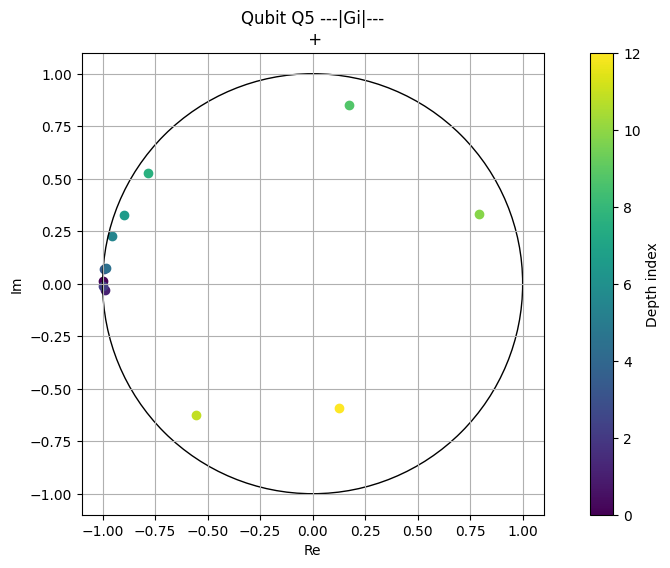

<Figure size 640x480 with 0 Axes>

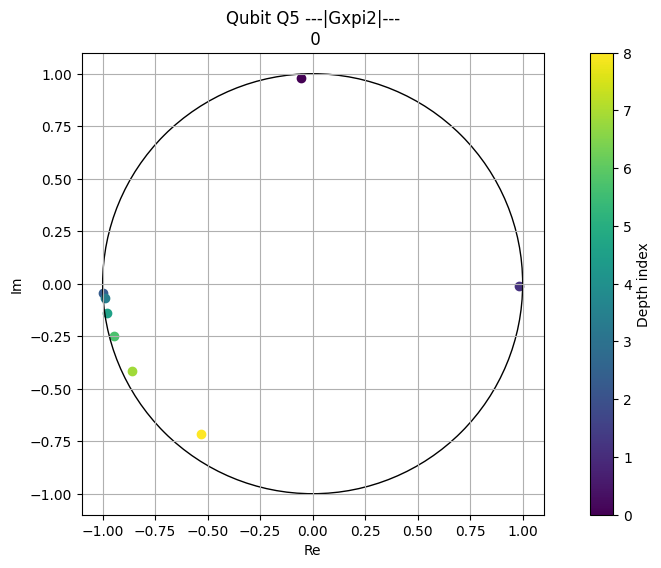

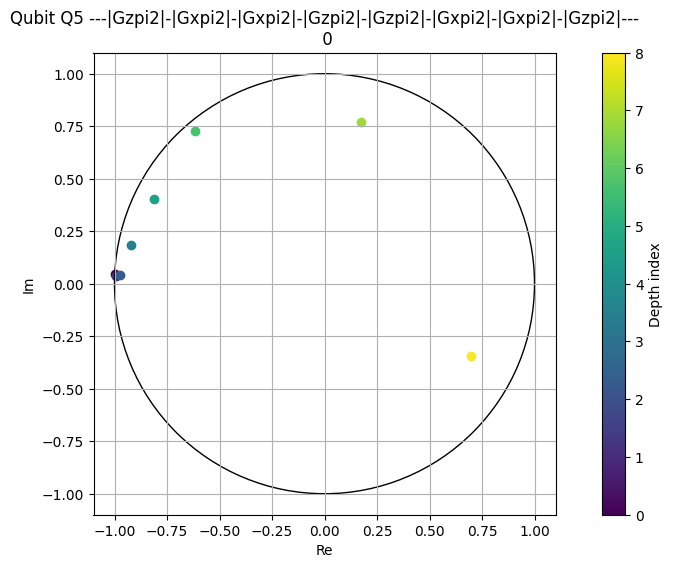

In [18]:
analysis_ramsey.plot_all_signals()
plt.figure()
analysis_xgate.plot_all_signals()

## Ramsey Tune-up

In [21]:
def collect_ramsey_datasets_from_control_series(cfg, initial_params, control_series, edesign, n_shots):
    datasets = []
    cfg = update_config_1qb(cfg, qid, initial_params[0], initial_params[1], initial_params[2])
    U = initial_params
    for idx, control in enumerate(control_series):
        print(f'Iteration {idx+1} of {len(control_series)}')
        U = U + np.array([control[0], 0, 0])
        cfg = update_config_1qb(cfg, qid, *U)
        ds = make_dataset(cfg, edesign, n_shots)
        datasets.append(ds)
    return datasets

def construct_ramsey_control_model_inversion_estimate(x_series, control_series):
    assert control_series[0] == np.zeros_like(control_series[0]) # first control series should be zeros
    assert len(x_series) == len(control_series) 
    x_diff = np.hstack([x_series[idx+1] - x_series[idx] for idx in range(len(x_series)-1)])
    U_partials = []
    for i in range(len(control_series[1:])):
        U_partial = np.array([
            control_series[i],
        ])
        U_partials.append(U_partial)
    U_partials = np.array(U_partials)
    U_tot = np.vstack(U_partials)
    x_diff = np.array(x_diff)
    # solve x_diff = U_tot * B
    return np.linalg.lstsq(U_tot, x_diff, rcond=None)

In [22]:
def sigma_points_from_covar(covar, alpha=1, kappa=0):
    n = covar.shape[0]
    lam = alpha**2 * (n + kappa) - n
    sigmas = np.zeros((2*n+1, n))
    sigmas[0] = np.zeros(n)
    sigmas[1:n+1] = np.linalg.cholesky((n + lam) * covar)
    sigmas[n+1:] = -sigmas[1:n+1]
    return sigmas

def control_model_edesign_sampling_strategy(covar, alpha=1, kappa=0):
    sigmas = sigma_points_from_covar(covar, alpha, kappa)
    n = covar.shape[0]
    us = [np.zeros(len(sigmas[0]))]
    for i in range(n):
        us.append(sigmas[i+1])
        us.append(sigmas[n+i+1])
        us.append(sigmas[n+i+1])
        us.append(sigmas[i+1])
    return np.array(us)

def make_random_control_series(sampling_covar, n_samples):
    control_series = []
    for i in range(n_samples):
        gaussian_perturbation = np.random.multivariate_normal([0, 0, 0], sampling_covar)
        control_series.append(gaussian_perturbation)
    return control_series

In [23]:
initial_params_Q5 = np.array([5575398505.67948, 0.12292, 0.21493])
qids = ['Q5']
qid = qids[0]
ramsey_depths = [2**i for i in range(12)]
depths = [2**i for i in range(8)]
n_shots = 512
edesign_ramsey = EDesign_Ramsey(ramsey_depths, qids)
edesign_X1Q = EDesign_X1Q(depths, qids)

NameError: name 'EDesign_X1Q' is not defined

In [163]:
ramsey_covar = np.array([[1e12]])
print(np.sqrt(np.diag(ramsey_covar)))

ramsey_control_series = control_model_edesign_sampling_strategy(ramsey_covar)
print(ramsey_control_series)


[1000000.]
[[       0.]
 [ 1000000.]
 [-1000000.]
 [-1000000.]
 [ 1000000.]]


Reading /home/jpmarceaux/experiment/data/2024-10-30/20241030_124338/RPE_dataset.txt: 100%
{'idle': -0.0008498561274752348}
{'idle': 0.12483806025067778}
{'idle': -0.00082783619431126}
{'idle': -0.12650636723490827}
{'idle': -0.0009321167691918042}


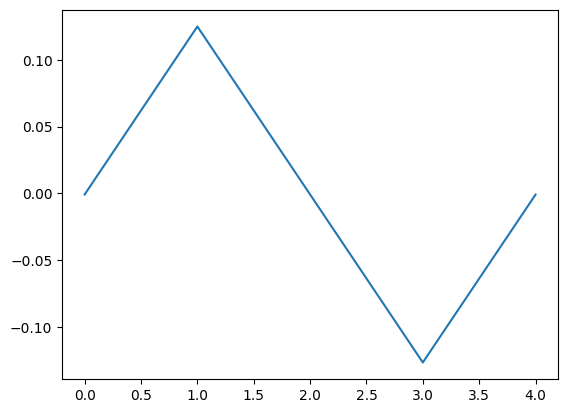

In [164]:
ramsey_control_series_datasets = collect_ramsey_datasets_from_control_series(cfg, initial_params_Q5, ramsey_control_series, edesign_ramsey, 512)
ramsey_anlayses = [Analysis_Ramsey(ds, edesign_ramsey) for ds in ramsey_control_series_datasets]

for r in ramsey_anlayses:
    print(r.estimates)

x_ramsey = [a.estimates['idle'] for a in ramsey_anlayses]
plt.plot(x_ramsey)

In [165]:
ramsey_least_squares = construct_ramsey_control_model_inversion_estimate(x_ramsey, ramsey_control_series)
B_ramsey = ramsey_least_squares[0]
print(B_ramsey)

[-4.1853872e-08]


In [166]:
from control import dlqr

In [167]:
def riccati_recursion(P, B, M, N, S):
    return M + P - (S.T + B.T @ P).T @ np.linalg.inv(N + B.T @ P @ B) @ (S.T + B.T @ P) 

class LQR:
    def __init__(self, num_iterations, B, M_final, M, N, S):
        """
        Cost function: J = x'Mx + u'Nu + 2x'Su
        """
        self.num_iterations = num_iterations
        self.M_final = M_final
        self.B = B
        self.M = M
        self.N = N
        self.S = S

        self.riccati_covars = self._make_riccati_covars()

    def _make_riccati_covars(self):
        riccati_covars = [self.M_final]
        for i in range(self.num_iterations-1):
            riccati_covars.append(riccati_recursion(riccati_covars[-1], self.B, self.M, self.N, self.S))
        return riccati_covars[::-1]

    def calc_gain(self, riccati_covar):
        P = riccati_covar
        return np.linalg.inv(self.N + self.B.T @ P @ self.B) @ (self.S.T + self.B.T @ P)
    
    def gain_schedule(self):
        return [self.calc_gain(riccati_covar) for riccati_covar in self.riccati_covars]

In [168]:
def k_step_lqr_ramsey_tuneup(cfg, initial_controls, gain_schedule, edesign):
    analysis_series = []
    xhat_series = []
    controls = []
    cfg = update_config_1qb(cfg, qid, initial_controls[0], initial_controls[1], initial_controls[2])
    print(f'Initial control with drive freq {initial_controls[0]}')
    ds = make_dataset(cfg, edesign, 512)
    analysis = Analysis_Ramsey(ds, edesign)
    analysis_series.append(analysis)
    x = np.array([analysis.estimates['idle']])
    initial_residual = x
    xhat_series.append(x)
    print(f'Initial residual error: {x}')
    U = initial_controls
    for i in range(len(gain_schedule)):
        u_i = np.dot(gain_schedule[i], x)
        U = U + np.array([u_i[0], 0, 0])
        print(f'Control step {i+1} with drive freq {U[0]}')
        controls.append(U)
        cfg = update_config_1qb(cfg, qid, *U)
        ds = make_dataset(cfg, edesign, 512)
        analysis = Analysis_Ramsey(ds, edesign)
        analysis_series.append(analysis)
        x = np.array([analysis.estimates['idle']])
        xhat_series.append(x)
        print(f'Finished step {i+1}')
        print(f'Residual error: {x}')
    print(f'Initial residual error: {initial_residual}')

    return analysis_series, xhat_series, controls

In [169]:
MK_ramsey = np.diag([1])
M_ramsey = np.diag([1])
N_ramsey = np.diag([1e-14])
S_ramsey = np.zeros((1, 1))
lqr_ramsey = LQR(5, B_ramsey, MK_ramsey, M_ramsey, N_ramsey, S_ramsey)
gain_schedule = lqr_ramsey.gain_schedule()
print(gain_schedule)

[array([[-7914652.01954419]]), array([[-7649762.78571126]]), array([[-7067113.35988226]]), array([[-5850076.36882507]]), array([[-3561502.25062306]])]


In [170]:
analysis_series, xhat_series, controls = k_step_lqr_ramsey_tuneup(cfg, initial_params_Q5+ np.array([1e7, 0, 0]), gain_schedule, edesign_ramsey)

Reading /home/jpmarceaux/experiment/data/2024-10-30/20241030_124542/RPE_dataset.txt: 100%
Finished step 5
Residual error: [0.00024492]
Initial residual error: [0.85618371]


Text(0, 0.5, 'Residual idle gate error')

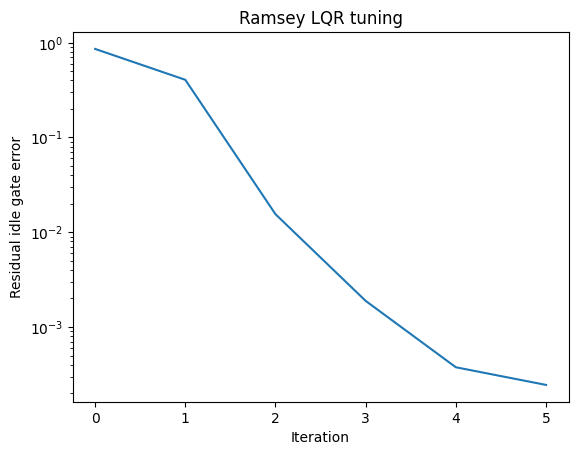

In [171]:
plt.semilogy(abs(np.array(xhat_series)))
plt.title('Ramsey LQR tuning')
plt.xlabel('Iteration')
plt.ylabel('Residual idle gate error')

In [173]:
final_ramsey_tuned_controls = controls[-1]
print(final_ramsey_tuned_controls)

[5.57540718e+09 1.22920000e-01 2.14930000e-01]


# X-gate Tuneup

In [196]:
def collect_xgate_datasets_from_control_series(cfg, initial_params, control_series, edesign, n_shots):
    datasets = []
    cfg = update_config_1qb(cfg, qid, initial_params[0], initial_params[1], initial_params[2])
    U = initial_params
    for idx, control in enumerate(control_series):
        print(f'Iteration {idx+1} of {len(control_series)}')
        U = U + np.array([0, control[0], control[1]])
        cfg = update_config_1qb(cfg, qid, *U)
        ds = make_dataset(cfg, edesign, n_shots)
        datasets.append(ds)
    return datasets

def construct_xgate_control_model_inversion_estimate(x_series, control_series):
    assert np.all(control_series[0] == np.zeros_like(control_series[0])) # first control series should be zeros
    assert len(x_series) == len(control_series) 
    x_diff = np.hstack([x_series[idx+1] - x_series[idx] for idx in range(len(x_series)-1)])
    U_partials = []
    for i in range(len(control_series[1:])):
        U_partial = np.array([
            np.hstack([control_series[i], np.zeros(2)]), 
            np.hstack([np.zeros(2), control_series[i]])
        ])
        U_partials.append(U_partial)
    U_partials = np.array(U_partials)
    U_tot = np.vstack(U_partials)
    x_diff = np.array(x_diff)
    # solve x_diff = U_tot * B
    return np.linalg.lstsq(U_tot, x_diff, rcond=None)

In [177]:
xgate_covar = np.diag([5e-5, 1e-4])
print(np.sqrt(np.diag(xgate_covar)))
xgate_control_series = control_model_edesign_sampling_strategy(xgate_covar)
print(xgate_control_series)

[0.00707107 0.01      ]
[[ 0.          0.        ]
 [ 0.01        0.        ]
 [-0.01       -0.        ]
 [-0.01       -0.        ]
 [ 0.01        0.        ]
 [ 0.          0.01414214]
 [-0.         -0.01414214]
 [-0.         -0.01414214]
 [ 0.          0.01414214]]


In [ ]:
xgate_datasets = collect_xgate_datasets_from_control_series(cfg, final_ramsey_tuned_controls, xgate_control_series, edesign_X1Q, 512)
xgate_analyses = [Analysis_Xgate(ds, edesign_X1Q) for ds in xgate_datasets]
xhats = np.array([[a.estimates['X overrot'], a.estimates['X axis']] for a in xgate_analyses])

Reading /home/jpmarceaux/experiment/data/2024-10-30/20241030_125031/RPE_dataset.txt: 100%


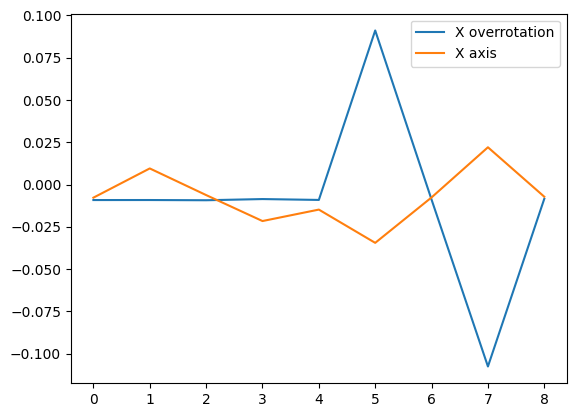

In [192]:
plt.plot(xhats[:, 0], label='X overrotation')
plt.plot(xhats[:, 1], label='X axis')
plt.legend()

In [286]:
lse = construct_xgate_control_model_inversion_estimate(xhats, xgate_control_series)
Bhat_xgate = lse[0].reshape(2, 2)
print(Bhat_xgate)

[[ 2.49602476 -2.36962165]
 [-0.67025879  0.62378318]]


In [287]:
MK_xgate = np.diag([1, 1])
M_xgate = np.diag([1, 1])
N_xgate = np.diag([100, 1])
S_xgate = np.zeros((2, 2))
lqr_xgate = LQR(5, Bhat_xgate, MK_xgate, M_xgate, N_xgate, S_xgate)
gain_schedule = lqr_xgate.gain_schedule()
print(gain_schedule)

[array([[ 0.00343781, -0.00155796],
       [-0.34135592,  0.08919044]]), array([[ 0.00346995, -0.00143587],
       [-0.34132199,  0.0893192 ]]), array([[ 0.00350209, -0.00131378],
       [-0.34128659,  0.08944758]]), array([[ 0.00353323, -0.00119142],
       [-0.34115781,  0.08955137]]), array([[ 0.00350234, -0.00105273],
       [-0.33514722,  0.08810649]])]


In [288]:
xhats.shape

(9, 2)

In [ ]:
def k_step_lqr_xgate_tuneup(cfg, initial_controls, gain_schedule, edesign):
    analysis_series = []
    xhat_series = []
    controls = []
    cfg = update_config_1qb(cfg, qid, initial_controls[0], initial_controls[1], initial_controls[2])
    print(f'Initial phase and amp: {initial_controls[1]}, {initial_controls[2]}')
    ds = make_dataset(cfg, edesign, 512)
    analysis = Analysis_Xgate(ds, edesign)
    analysis_series.append(analysis)
    x = np.array([analysis.estimates['X overrot'], analysis.estimates['X axis']])
    initial_residual = x
    xhat_series.append(x)
    print(f'Initial residual error: {x}')
    U = initial_controls
    for i in range(len(gain_schedule)):
        u_i = -np.dot(gain_schedule[i], x)
        U = U + np.array([0, u_i[0], u_i[1]])
        if U[2] < 0:
            print('Clipping negative amplitude')
            U[2] = 0
        print(f'Control step {i+1} with phase and amp: {U[1]}, {U[2]}')
        controls.append(U)
        cfg = update_config_1qb(cfg, qid, *U)
        ds = make_dataset(cfg, edesign, 512)
        analysis = Analysis_Xgate(ds, edesign)
        analysis_series.append(analysis)
        x = np.array([analysis.estimates['X overrot'], analysis.estimates['X axis']])
        xhat_series.append(x)
        print(f'Finished step {i+1}')
        print(f'Residual error: {x}')
    print(f'Initial residual error: {initial_residual}')

    return analysis_series, xhat_series, controls

In [290]:
offset = np.array([0, 0.0, 0.1])
xgate_analysis_series, xgate_xhat_series, xgate_controls = k_step_lqr_xgate_tuneup(cfg, final_ramsey_tuned_controls+offset, gain_schedule, edesign_X1Q)

Reading /home/jpmarceaux/experiment/data/2024-10-30/20241030_135350/RPE_dataset.txt: 100%
Finished step 5
Residual error: [-0.29761454  0.90088856]
Initial residual error: [ 0.6929893  -0.11422383]


In [265]:
xgate_xhat_series

[array([ 0.68479849, -0.09971293]),
 array([-2.44830256, -2.56483305]),
 array([-1.57780533,  0.01566288]),
 array([-0.2157437 ,  0.75842677]),
 array([-1.69799979, -0.00665638]),
 array([-2.44494009, -2.51771928])]

In [266]:
xgate_controls

[array([ 5.57540718e+09, -5.85034022e+00, -6.31851134e+00]),
 array([5.57540718e+09, 2.34185027e+02, 2.47550045e+02]),
 array([5.57540718e+09, 2.64075007e+02, 2.79699761e+02]),
 array([5.57540718e+09, 2.11595677e+02, 2.24512993e+02]),
 array([5.57540718e+09, 2.45515697e+02, 2.60958369e+02])]

# CZ

In [ ]:
qids = ['Q4', 'Q5']
depths = [2**i for i in range(6)]
n_shots = 512
edesign = EDesign_CZ(depths, qids)
circuits = edesign.circuit_list

In [ ]:
transpiler = Transpiler()
tcircuits = transpiler.transpile(circuits)

cfg.load()

cfg['readout/esp/enable'] = False
qpu = QubicQPU(
    cfg,
    classifier=classifier,
    n_circs_per_seq=250,
    reload_pulse=False,
    zero_between_reload=False
)
qpu.run(tcircuits)

INFO:QPU: Data save location: /home/jpmarceaux/experiment/data/2024-10-28/20241028_114836/



Runtime:   Compile  Transpile  Sequencing  Write  Measure  Process  Total
Time (s)      0.0        0.0         0.3    0.0     33.4      0.1   33.9



In [ ]:
generate_pygsti_dataset(tcircuits, qpu.data_manager.save_path + 'RPE_CZ')
ds_location = qpu.data_manager.save_path + 'RPE_CZdataset.txt'
ds = pygsti.io.load_dataset(ds_location)
analysis = Analysis_CZ(ds, edesign)
analysis.estimates

Reading /home/jpmarceaux/experiment/data/2024-10-28/20241028_114836/RPE_CZdataset.txt: 100%


{'IZ': -0.5245488079525105,
 'ZI': -0.400698894729258,
 'ZZ': 0.07464669769337551}

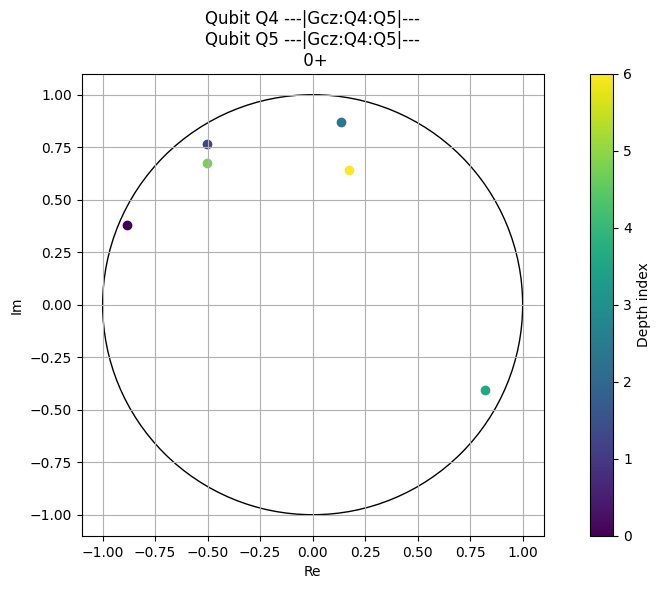

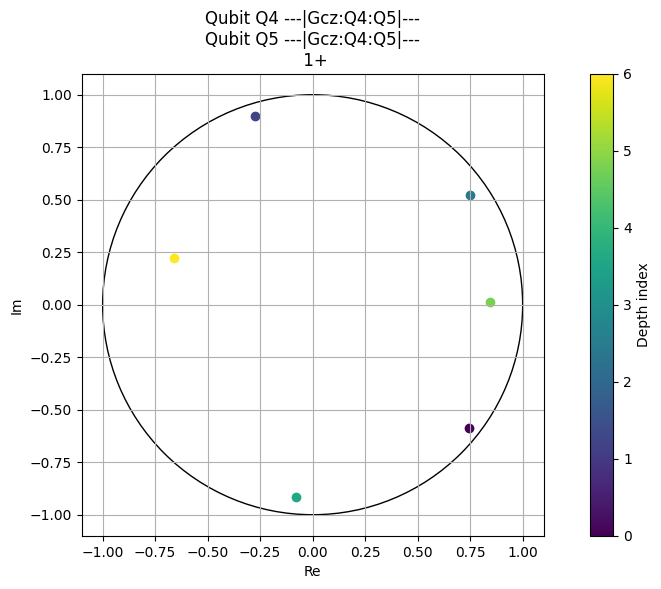

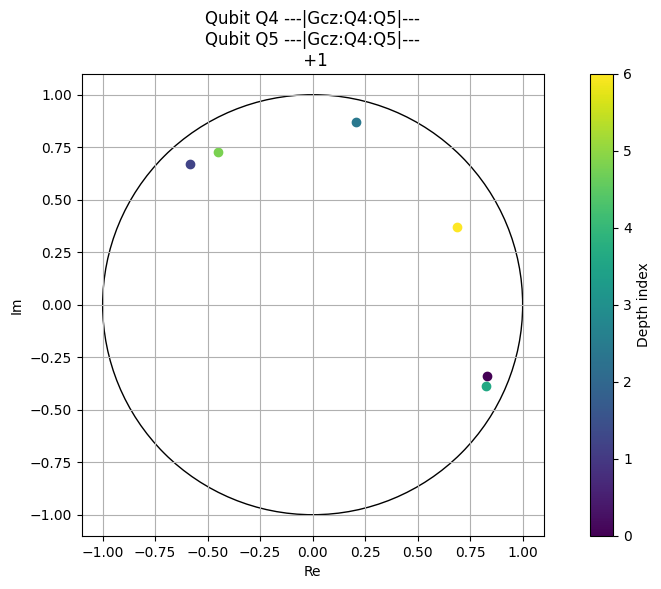

In [ ]:
analysis.plot_all_signals()